In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Данные и метрики

In [2]:
data_iris = pd.read_csv("iris.csv")
data_iris = data_iris.drop_duplicates()
X_iris = data_iris.drop(['species'], axis=1)

data_mall = pd.read_csv('Mall_Customers.csv')
data_mall = data_mall.drop_duplicates()
data_mall = data_mall.drop(['CustomerID'], axis=1)
X_mall = data_mall.drop(['Gender'], axis=1)

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

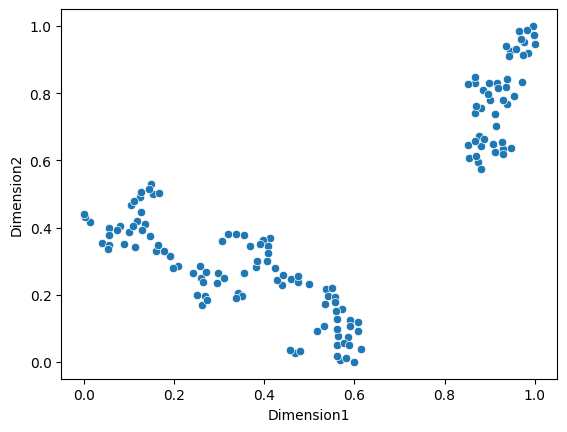

In [3]:
scaler = StandardScaler()
data_iris_scaled = scaler.fit_transform(X_iris.select_dtypes(include=[np.number]))
data_iris_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10, random_state=0).fit_transform(X=data_iris_scaled)
mmscaler = MinMaxScaler()
data_iris_mm = mmscaler.fit_transform(data_iris_tsne)
data_iris_tsne_df = pd.DataFrame(data=data_iris_mm, columns=["Dimension1", "Dimension2"])
sns.scatterplot(data=data_iris_tsne_df, x='Dimension1', y='Dimension2')

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

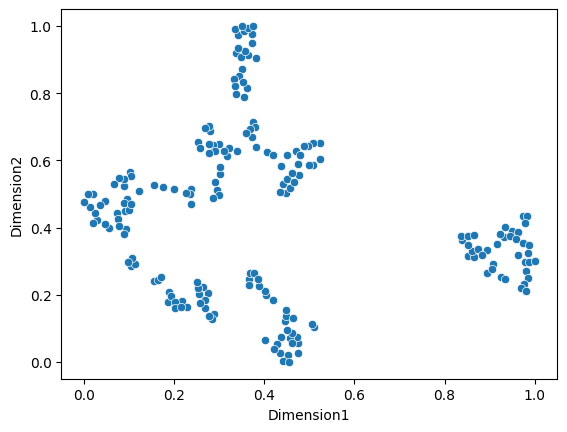

In [4]:
scaler = StandardScaler()
data_mall_scaled = scaler.fit_transform(X_mall.select_dtypes(include=[np.number]))
data_mall_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10, random_state=0).fit_transform(X=data_mall_scaled)
mmscaler = MinMaxScaler()
data_mall_mm = mmscaler.fit_transform(data_mall_tsne)
data_mall_tsne_df = pd.DataFrame(data=data_mall_mm, columns=["Dimension1", "Dimension2"])
sns.scatterplot(data=data_mall_tsne_df, x='Dimension1', y='Dimension2')

In [5]:
# межкластерное расстояние
def outer_cluster_distance(clusters, cluster_labels):
    distances = []
    for label in cluster_labels:
        cluster = clusters[clusters['flag'] == label]
        sum_dist = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in clusters[clusters['flag'] != label].iterrows():
                sum_dist += np.linalg.norm(np.array(row) - np.array(row_))
        distances.append(sum_dist / len(cluster))
    return sum(distances)


# внутрикластерное расстояние
def inner_cluster_distance(clusters, cluster_labels):
    distances = []
    for label in cluster_labels:
        cluster = clusters[clusters['flag'] == label]
        sum_dist = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in cluster.iterrows():
                if idx < jdx:
                    sum_dist += np.linalg.norm(np.array(row) - np.array(row_))
        distances.append(sum_dist / len(cluster))
    return sum(distances)

# Иерархическая кластеризация

In [6]:
cluster_df_iris = []

for idx, row in data_iris_tsne_df.iterrows():
    cluster_df_iris.append(tuple(row))

cluster_df_mall = []

for idx, row in data_mall_tsne_df.iterrows():
    cluster_df_mall.append(tuple(row))

In [7]:
# точки кластера
def points(cluster):
    i = 0
    pts = []
    str_cluster = str(cluster)
    for symbol in str_cluster:
        if symbol == '(' and str_cluster[i+1] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-']:
            pts.append(str_cluster[i-1:str_cluster[i-1:].find(')')+i].replace('(', '').replace(')', ''))
        else:
            pass
        i += 1
    return pts

In [8]:
# алгоритм кластеризации
def hierarchical_clustering(cluster_data):
    clusters = [cluster_data]
    distances = {}
    indexes_1, indexes_2, dists, lens = [], [], [], []

    for i in range(1, len(cluster_data) + 1):
        min_dist = float('inf')

        # конец кластеризации
        if len(clusters[-1]) == 1:
            max_diff = 0
            for j in range(len(dists) - 1):
                if abs(dists[j + 1] - dists[j]) > max_diff:
                    max_diff = abs(dists[j + 1] - dists[j])
                    index = j

            matrix = np.array([indexes_1, indexes_2, dists, lens])
            return clusters[index], matrix

        if i == 1:
            # первый шаг кластеризации
            for k in range(len(clusters[i - 1])):
                for j in range(len(clusters[i - 1])):
                    if k != j:
                        dist = np.linalg.norm(np.array(clusters[i - 1][k]) - np.array(clusters[i - 1][j]))
                        distances[(clusters[i - 1][k], clusters[i - 1][j])] = dist
                        if dist < min_dist:
                            min_dist, min_1, min_2 = dist, clusters[i - 1][k], clusters[i - 1][j]
        else:
            # последующие шаги кластеризации
            for key, value in distances.items():
                if value < min_dist:
                    min_dist, min_1, min_2 = value, key[0], key[1]

        # добавление информации о кластерах
        if i == 1:
            clusters_indexes = clusters[-1]
        else:
            clusters_indexes.append(new_cluster)

        new_cluster = (min_1, min_2)
        
        indexes_1.append(clusters_indexes.index(min_1))
        indexes_2.append(clusters_indexes.index(min_2))
        dists.append(min_dist)
        lens.append(len(points(min_1)) + len(points(min_2)))

        # добавление состояния кластеров в список
        cluster_copy = clusters[-1].copy()
        cluster_copy.remove(min_1)
        cluster_copy.remove(min_2)
        clusters.append([*cluster_copy])

        # обновление расстояний между кластерами
        for s in clusters[-1]:
            v_s = distances.get((s, new_cluster[0]), distances.get((new_cluster[0], s)))
            u_s = distances.get((s, new_cluster[1]), distances.get((new_cluster[1], s)))
            distances[(new_cluster, s)] = 0.5 * (v_s + u_s + abs(v_s - u_s))

        for key in list(distances.keys()):
            if min_2 in key or min_1 in key:
                del distances[key]

        clusters[-1].append(new_cluster)


Сравнение работы ручного и библиотечного алгоритмов на наборе Iris

In [9]:
# кластеризация
start_time = datetime.datetime.now()
dendrogram_len = len(cluster_df_iris)
clusters, matrix = hierarchical_clustering(cluster_df_iris)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результата
res_iris = data_iris_tsne_df.copy().head(0)
res_iris['flag'] = []
row_num = 0
for idx, cluster in enumerate(clusters):
    for st in [[float(j) for j in i.split(',')] for i in points(cluster)]:
        st.append(idx)
        res_iris.loc[row_num] = st
        row_num += 1

# Вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, res_iris['flag'].unique())
outer_dist = outer_cluster_distance(res_iris, res_iris['flag'].unique())
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 11.880865208802376
Межкластерное расстояние (вручную): 454.5125475186916
Время работы (вручную): 0:00:00.569048


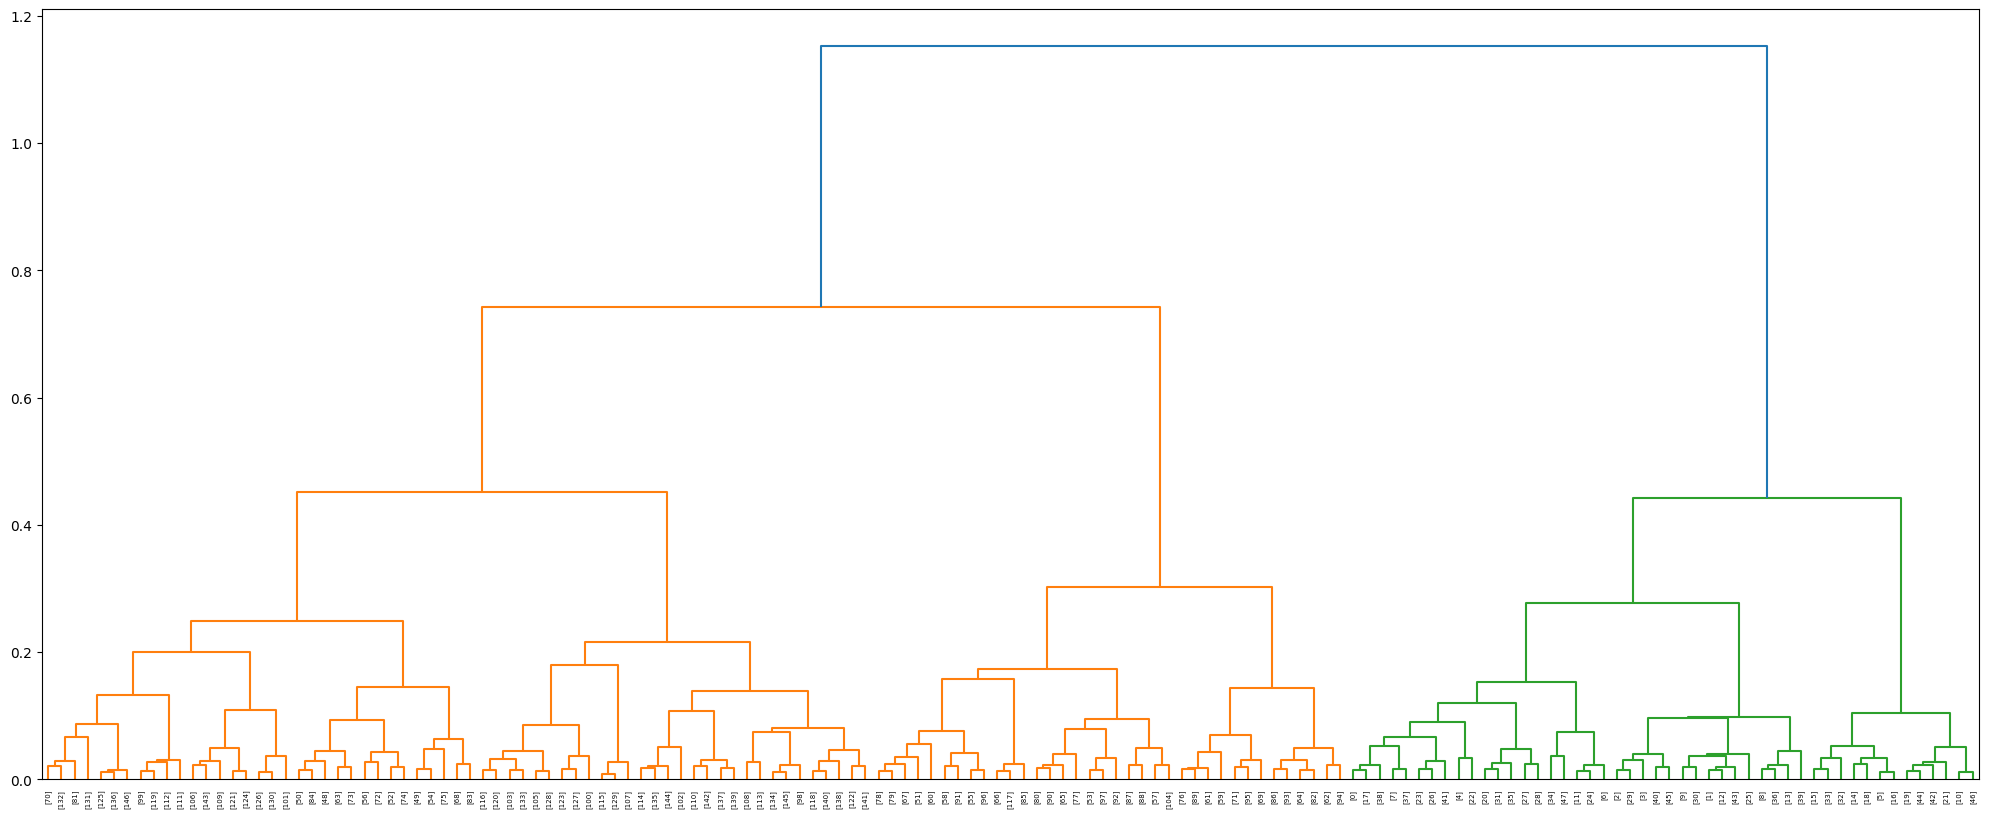

In [10]:
# дендрограмма
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(matrix.T, orientation='top', labels=[[i] for i in range(dendrogram_len)], show_leaf_counts=True)

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

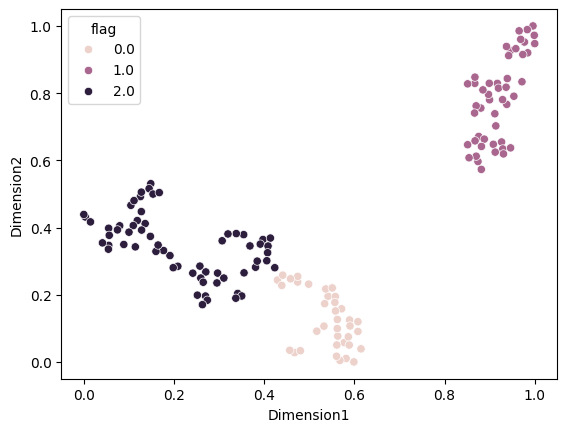

In [11]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

In [12]:
# кластеризация
start_time = datetime.datetime.now()
dendrogram_len = len(cluster_df_iris)
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(data_iris_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_iris = data_iris_tsne_df.copy()
res_iris['flag'] = list(clustering.labels_)

# вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, list(res_iris['flag'].unique()))
outer_dist = outer_cluster_distance(res_iris, list(res_iris['flag'].unique()))
print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 11.88086520880237
Межкластерное расстояние (библиотека): 454.51254751869226
Время работы (библиотека): 0:00:00.002985


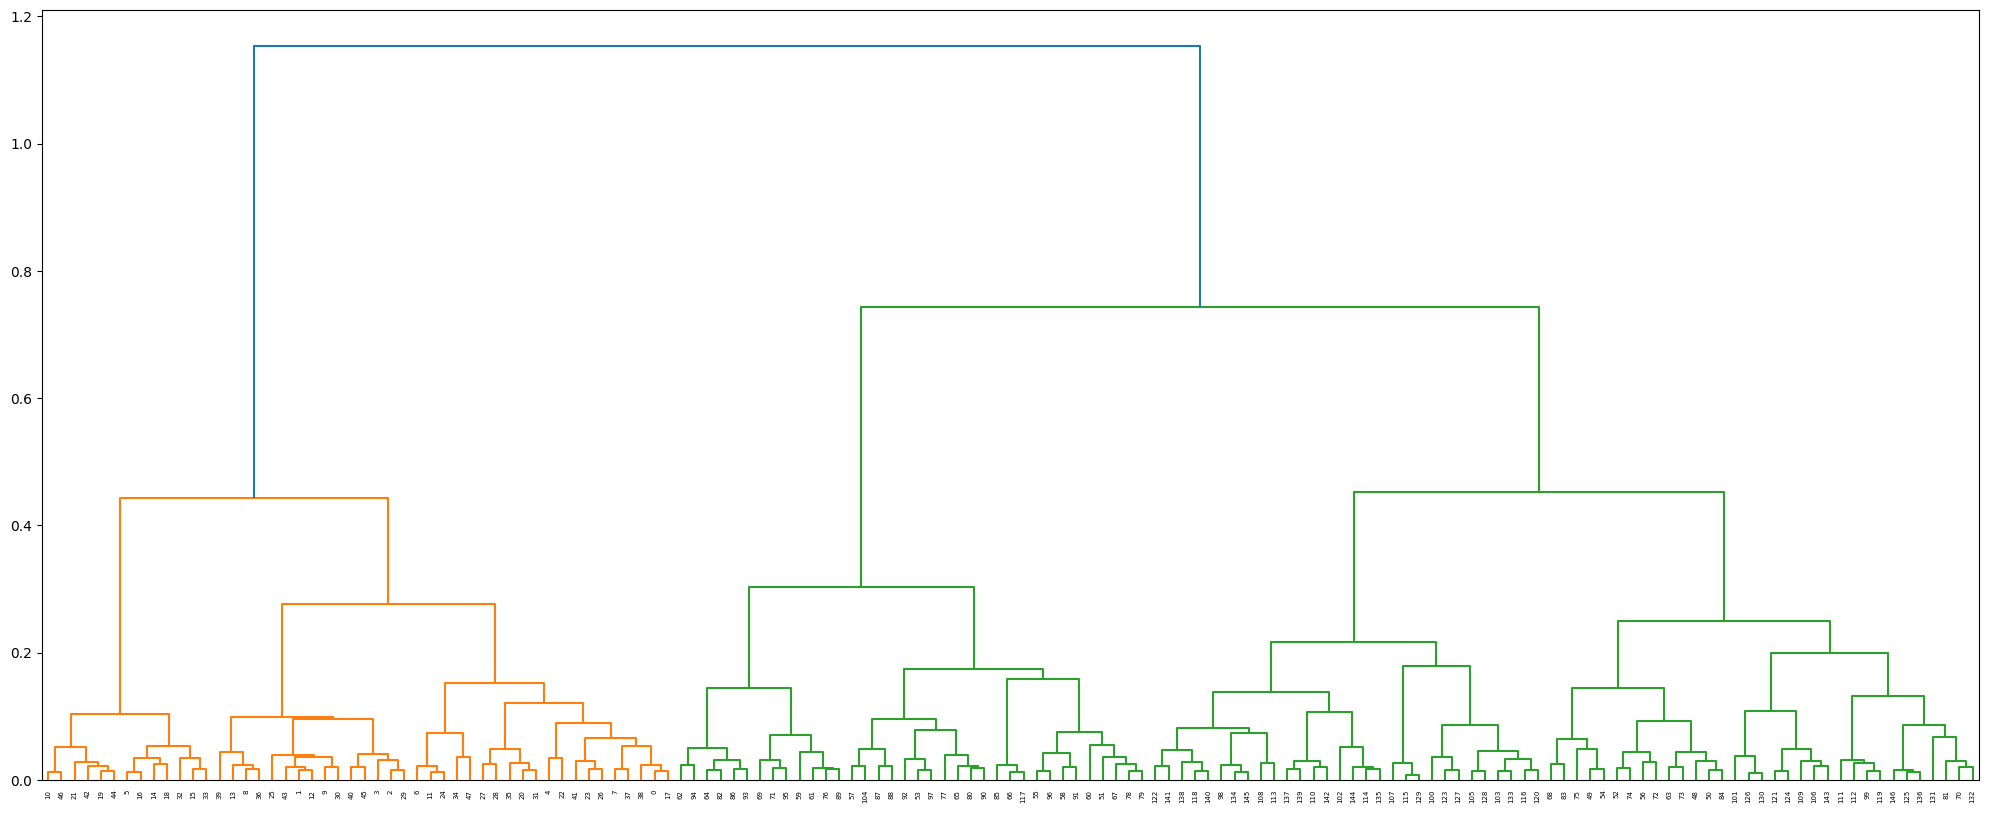

In [13]:
# дендрограмма
Z = linkage(data_iris_tsne_df, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

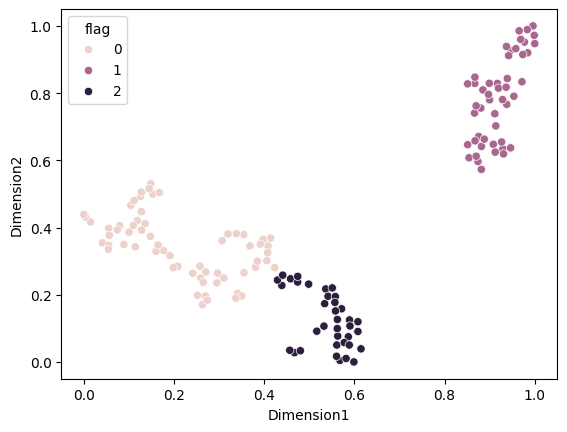

In [14]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

Сравнение работы ручного и библиотечного алгоритмов на наборе mall

In [15]:
# кластеризация
start_time = datetime.datetime.now()
dendrogram_len = len(cluster_df_mall)
clusters, matrix = hierarchical_clustering(cluster_df_mall)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результата
res_mall = data_mall_tsne_df.copy().head(0)
res_mall['flag'] = []
row_num = 0
for idx, cluster in enumerate(clusters):
    for st in [[float(j) for j in i.split(',')] for i in points(cluster)]:
        st.append(idx)
        res_mall.loc[row_num] = st
        row_num += 1

# Вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, res_mall['flag'].unique())
outer_dist = outer_cluster_distance(res_mall, res_mall['flag'].unique())
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 15.703341397367915
Межкластерное расстояние (вручную): 1072.012297695141
Время работы (вручную): 0:00:01.139259


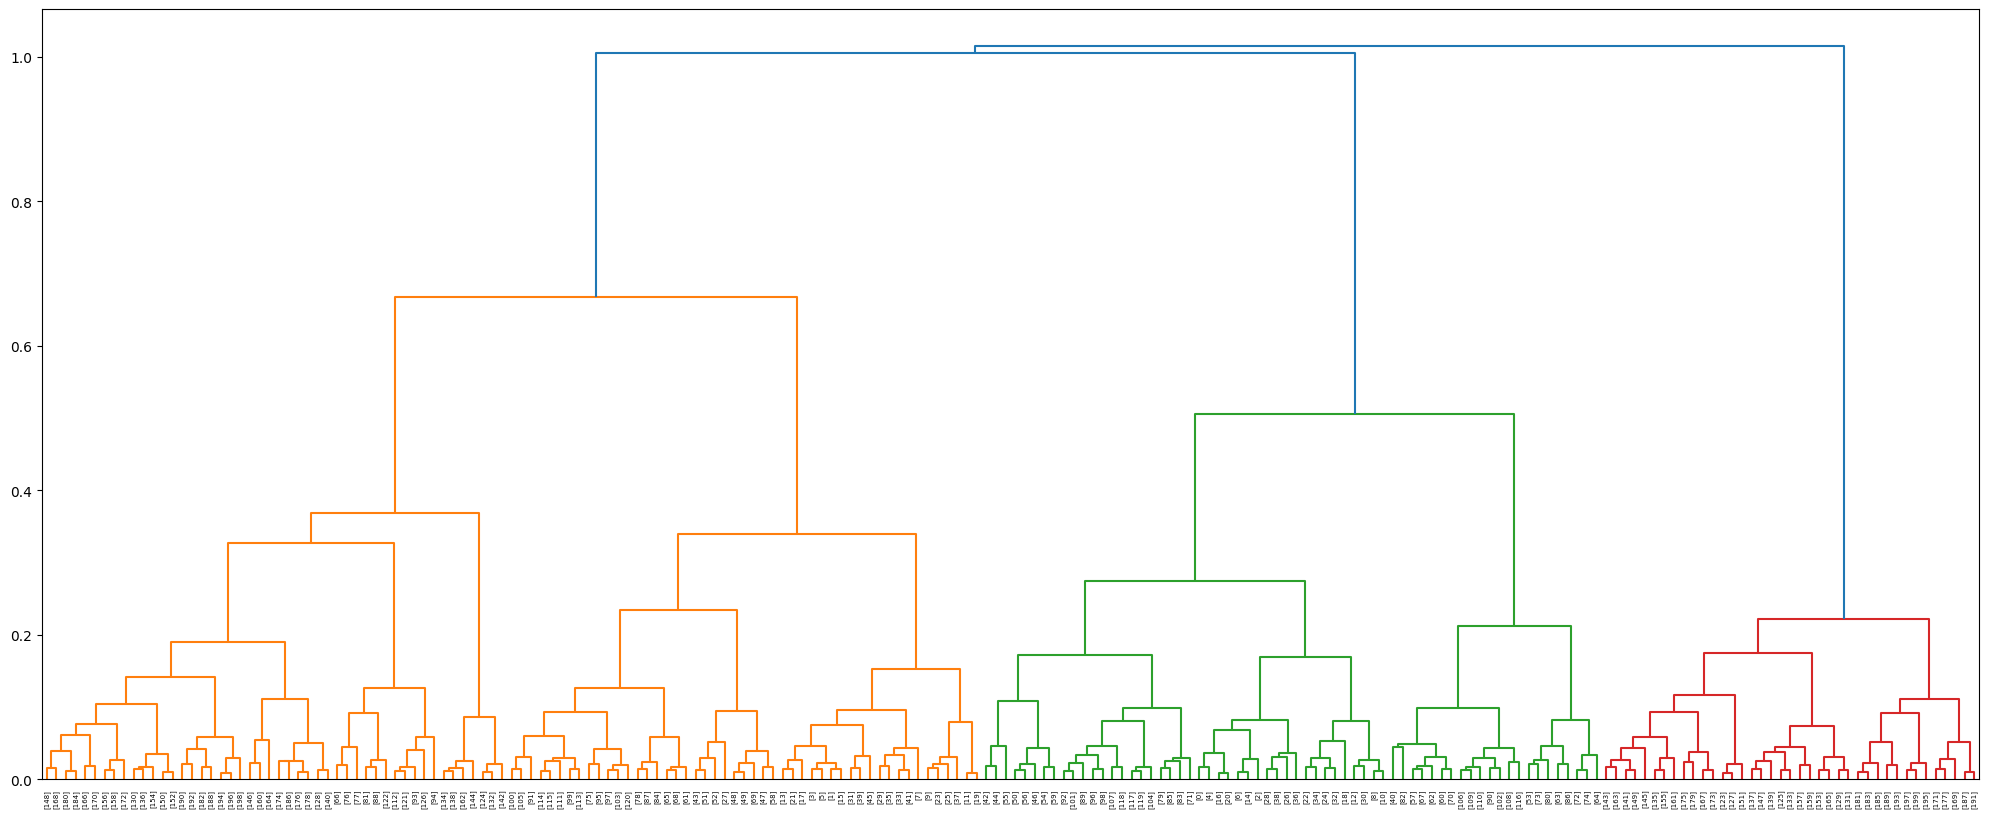

In [16]:
# дендрограмма
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(matrix.T, orientation='top', labels=[[i] for i in range(dendrogram_len)], show_leaf_counts=True)

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

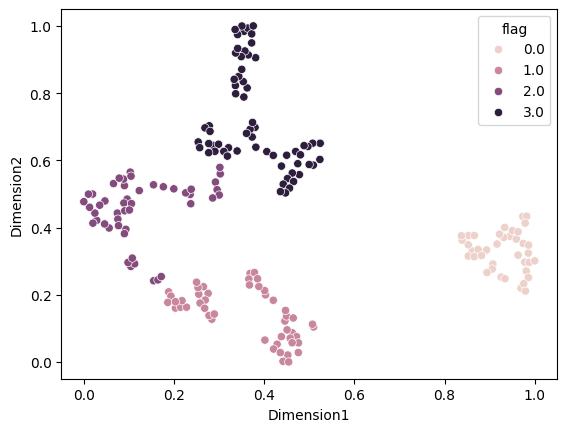

In [17]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')

In [18]:
# кластеризация
start_time = datetime.datetime.now()
clustering = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(data_mall_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_mall = data_mall_tsne_df.copy()
res_mall['flag'] = list(clustering.labels_)

# вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, list(res_mall['flag'].unique()))
outer_dist = outer_cluster_distance(res_mall, list(res_mall['flag'].unique()))
print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 15.703341397367938
Межкластерное расстояние (библиотека): 1080.7182562544137
Время работы (библиотека): 0:00:00.004010


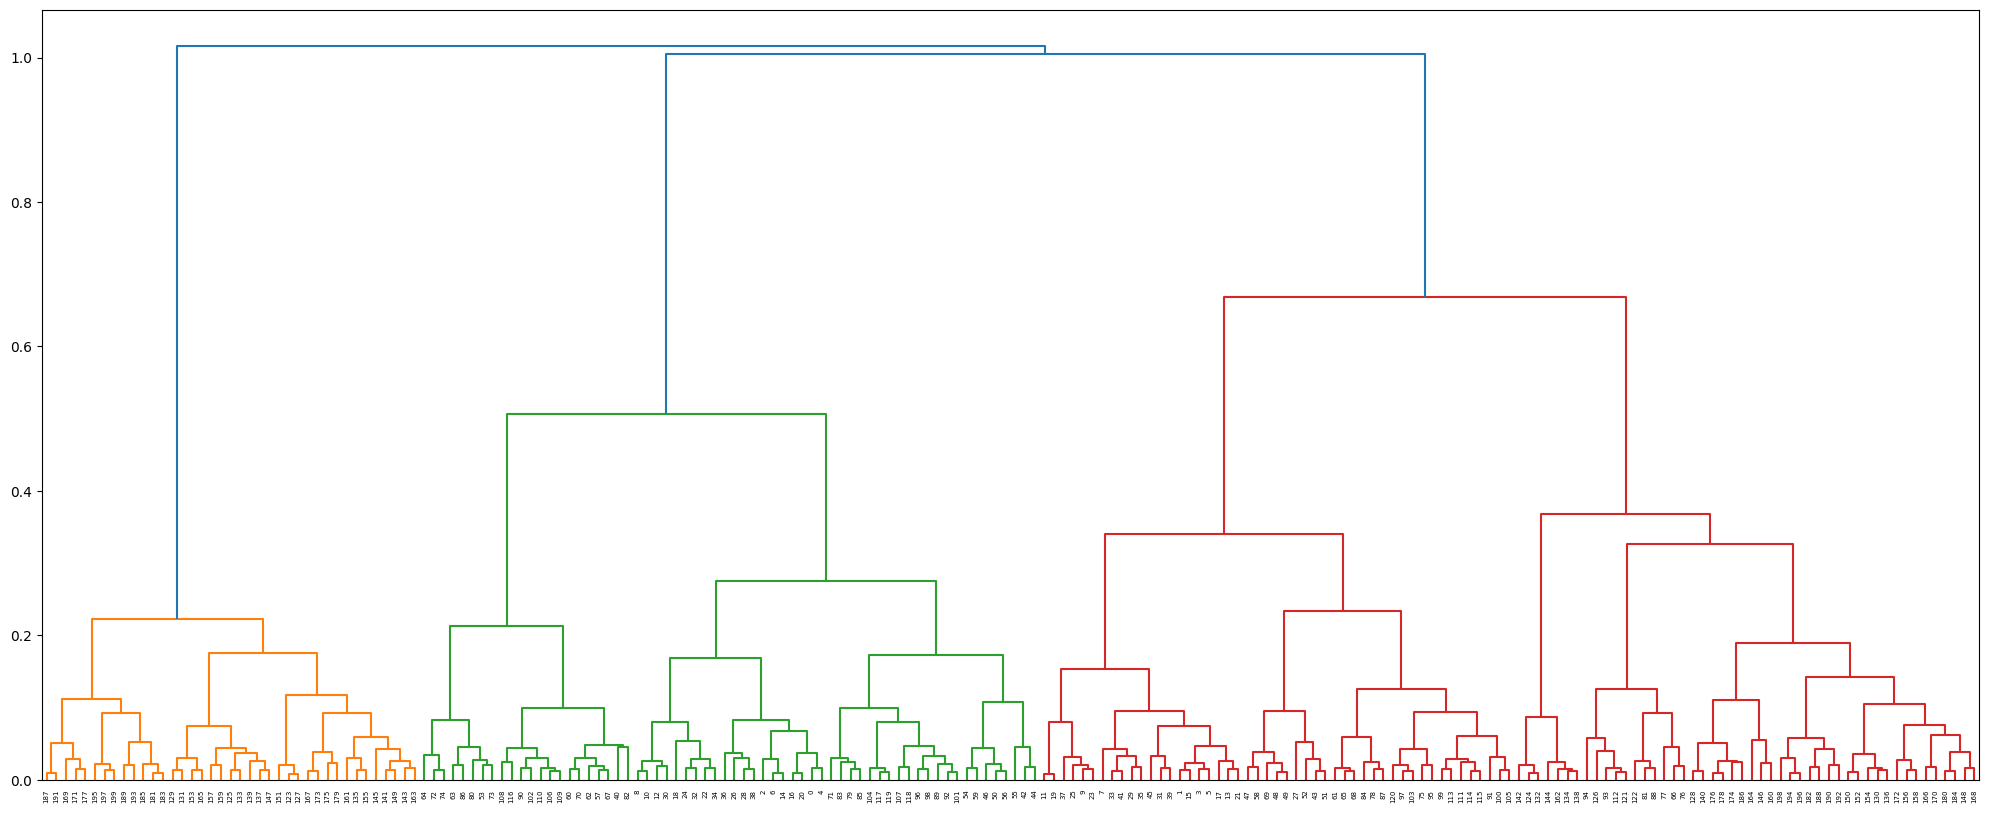

In [19]:
# дендрограмма
Z = linkage(data_mall_tsne_df, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

<Axes: xlabel='Dimension1', ylabel='Dimension2'>

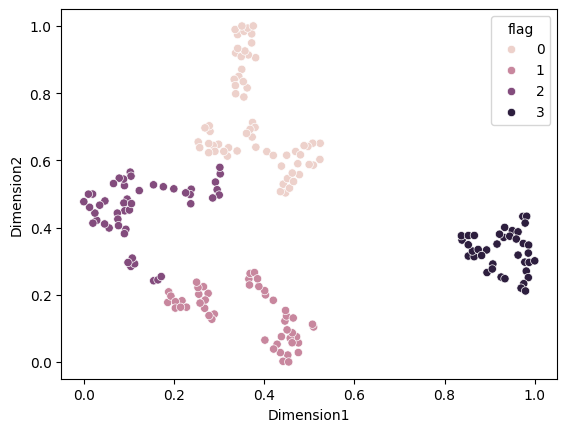

In [20]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')

# EM-кластеризация

In [21]:
cluster_df_iris = []
for idx, row in (data_iris_tsne_df * 20).iterrows():
    cluster_df_iris.append(tuple(row))

cluster_df_mall = []

for idx, row in (data_mall_tsne_df * 20).iterrows():
    cluster_df_mall.append(tuple(row))

In [22]:
def em_clustering(data, K, delta, iter_max):
    N = len(data)
    M = len(data[0])
    
    # начальные приближения
    w = [1 / K for _ in range(K)]
    mu = [random.choice(data) for _ in range(K)]

    it = 0
    diag_sum = 0
    row = []
    for k in range(K):
        for i in range(N):
            diag_sum += np.linalg.norm(np.array(data[i]) - np.array(mu[it]))
        it += 1
        row.append(diag_sum / (N * K))
    covs = [np.diag([row[i]] * M) for i in range(K)]

    y = []
    it = 0
    changes = True

    # основной цикл алгоритма
    while changes is True:
        gamma = {}
        for i in range(K):
            gamma[i] = []

        sigma = []
        for i in range(K):
            sigma.append(np.linalg.det(covs[i]))

        # expectation
        for n in range(N):
            p_x = []
            for k in range(K):
                mat_mul = np.linalg.norm(np.array(data[n]) - np.array(mu[k]))**2
                p_x.append(np.exp(-0.5 * mat_mul) / ((2 * np.pi) ** (N / 2) * sigma[k]**0.5))

            for k in range(K):
                gamma[k].append(w[k] * p_x[k] / sum([w[i] * p_x[i] for i in range(K)]))

        # maximization
        w = []
        mu = []
        covs = []
        for k in range(K):
            n_k = sum(gamma[k])

            w.append(n_k / N)

            vect = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(np.array(data[n])[j] * gamma[k][n])
                vect.append(sum(mult))

            mu.append(np.array(vect) / (N * w[-1]))


            sigma = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(gamma[k][n] * (np.array(data[n])[j] - mu[k][j]) ** 2)

                sigma.append(sum(mult) / (N * w[-1]))
            covs.append(np.diag(sigma))

        # обновление вероятностей
        y_i = []
        clusters = dict()
        for n in range(N):
            prob = dict()
            for k in range(K):
                prob[k] = gamma[k][n]

            max_p = max(prob.values())
            y_i.append(max_p)

            for key, value in prob.items():
                if value == max_p:
                    clusters[n] = key
                    break
        y.append(y_i)

        # проверка на изменения
        if it > 0:
            changes_num = 0
            for i in range(len(y_i)):
                new_delta = abs(y[-2][i] - y[-1][i])
                if new_delta > delta:
                    changes_num += 1
            if changes_num == 0:
                changes = False

        it += 1
    return clusters

Сравнение работы ручного и библиотечного алгоритмов на датасете Iris

In [23]:
# кластеризация
start_time = datetime.datetime.now()
clustering = em_clustering(cluster_df_iris, 3, 0.001, 100)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_iris = data_iris_tsne_df.copy()
res_iris['flag'] = list(clustering.values())

# вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, list(res_iris['flag'].unique()))
outer_dist = outer_cluster_distance(res_iris, list(res_iris['flag'].unique()))
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 11.93761722532072
Межкластерное расстояние (вручную): 443.59387872786186
Время работы (вручную): 0:00:00.353494


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

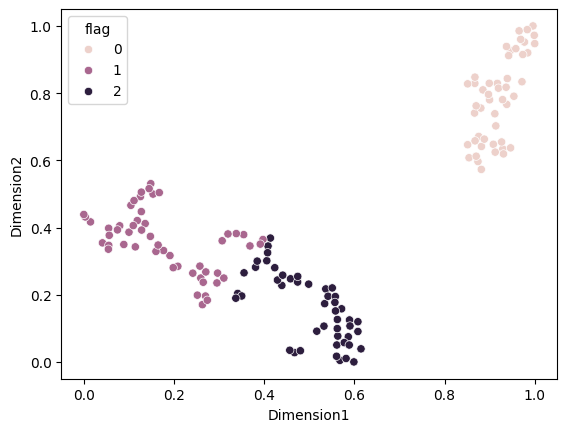

In [24]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

In [25]:
# кластеризация
start_time = datetime.datetime.now()
clustering = GaussianMixture(n_components=3).fit(data_iris_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
prediction = clustering.predict(data_iris_tsne_df)
res_iris = data_iris_tsne_df.copy()
res_iris['flag'] = list(prediction)

# вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, list(res_iris['flag'].unique()))
outer_dist = outer_cluster_distance(res_iris, list(res_iris['flag'].unique()))

print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 12.230746878396168
Межкластерное расстояние (библиотека): 454.8982834125578
Время работы (библиотека): 0:00:00.122002


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

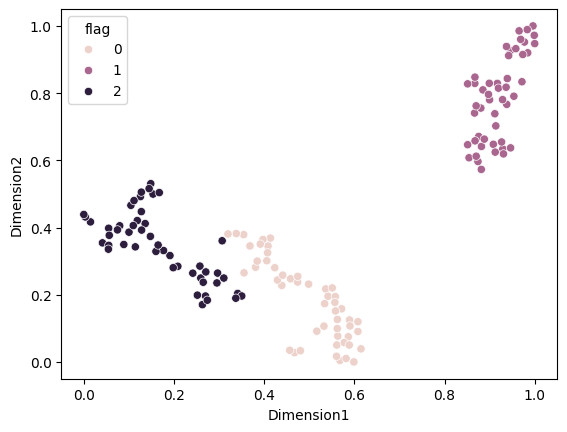

In [26]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

Сравнение работы ручного и библиотечного алгоритмов на датасете mall

In [27]:
# кластеризация
start_time = datetime.datetime.now()
clustering = em_clustering(cluster_df_mall, 4, 0.001, 100)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_mall = data_mall_tsne_df.copy()
res_mall['flag'] = list(clustering.values())

# вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, list(res_mall['flag'].unique()))
outer_dist = outer_cluster_distance(res_mall, list(res_mall['flag'].unique()))
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 15.596744759005338
Межкластерное расстояние (вручную): 1084.4564828020718
Время работы (вручную): 0:00:00.183016


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

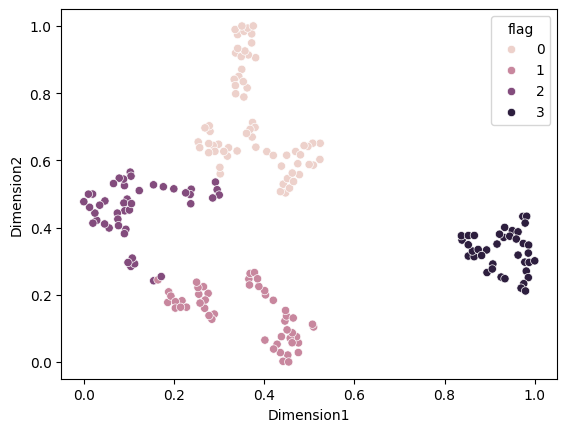

In [28]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')

In [29]:
# кластеризация
start_time = datetime.datetime.now()
clustering = GaussianMixture(n_components=4).fit(data_mall_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
prediction = clustering.predict(data_mall_tsne_df)
res_mall = data_mall_tsne_df.copy()
res_mall['flag'] = list(prediction)

# вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, list(res_mall['flag'].unique()))
outer_dist = outer_cluster_distance(res_mall, list(res_mall['flag'].unique()))

print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 15.81516768375786
Межкластерное расстояние (библиотека): 1085.7781911891457
Время работы (библиотека): 0:00:00.034988


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

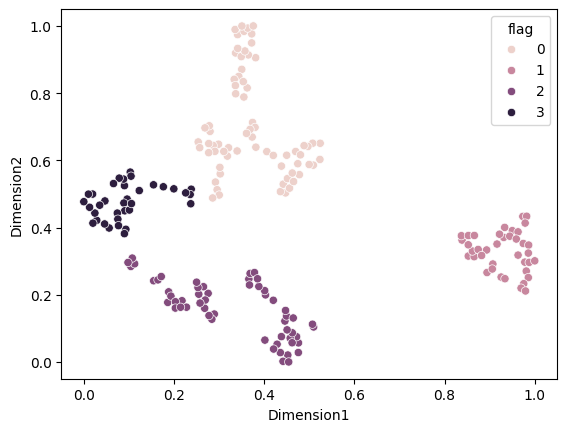

In [30]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')

# DBSCAN

In [31]:
cluster_df_iris = []

for idx, row in data_iris_tsne_df.iterrows():
    cluster_df_iris.append(tuple(row))

cluster_df_mall = []

for idx, row in data_mall_tsne_df.iterrows():
    cluster_df_mall.append(tuple(row))

In [32]:
def dbscan_clustering(data, eps, m):
    noise = -1
    a = -1

    visited_points = []
    clustered_points = []
    clusters = {noise: []}

    # цикл посещения точки
    for point in data:
        if point in visited_points:
            continue
        visited_points.append(point)

        # оценка количества соседей
        neighbors = [p for p in data if np.linalg.norm(np.array(point) - np.array(p)) < eps]
        if len(neighbors) < m:
            clusters[noise].append(point)
        else:
            # новый кластер
            a += 1
            if a not in clusters:
                clusters[a] = []
            clusters[a].append(point)
            clustered_points.append(point)

            # посещение соседей
            while neighbors:
                q = neighbors.pop()
                if q not in clustered_points:
                    clustered_points.append(q)
                    clusters[a].append(q)
                    if q in clusters[noise]:
                        clusters[noise].remove(q)
                if q not in visited_points:
                    visited_points.append(q)
                    q_neighbors = [p for p in data if np.linalg.norm(np.array(q) - np.array(p)) < eps]
                    if len(q_neighbors) > m:
                        neighbors.extend(q_neighbors)

    return clusters

Сравнение работы ручного и библиотечного алгоритмов на датасете Iris

In [33]:
# кластеризация
start_time = datetime.datetime.now()
clustering = dbscan_clustering(cluster_df_iris, 0.1, 2)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_iris = data_iris_tsne_df.copy().head(0)
res_iris['flag'] = list(clustering.values())
row_num = 0
for key, value in clustering.items():
    for v in value:
        row = list(v)
        row.append(key)
        res_iris.loc[row_num] = row
        row_num += 1

# вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, list(res_iris['flag'].unique()))
outer_dist = outer_cluster_distance(res_iris, list(res_iris['flag'].unique()))
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 17.572591602422865
Межкластерное расстояние (вручную): 190.4435938820269
Время работы (вручную): 0:00:00.136022


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

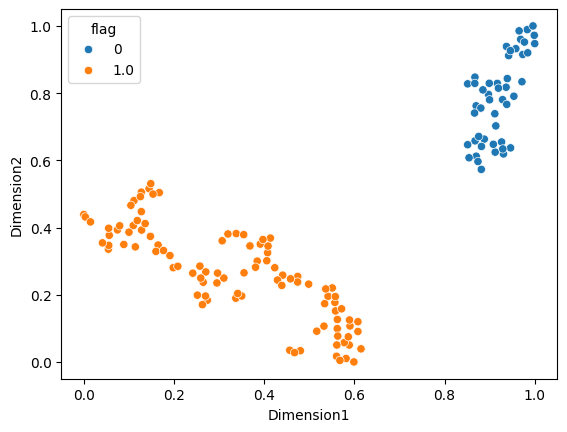

In [34]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

In [35]:
# кластеризация
start_time = datetime.datetime.now()
clustering = DBSCAN(eps=0.1, min_samples=2).fit(data_iris_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_iris = data_iris_tsne_df.copy()
res_iris['flag'] = clustering.labels_

# вычисление расстояний
inner_dist = inner_cluster_distance(res_iris, list(res_iris['flag'].unique()))
outer_dist = outer_cluster_distance(res_iris, list(res_iris['flag'].unique()))
print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 17.57259160242286
Межкластерное расстояние (библиотека): 190.443593882027
Время работы (библиотека): 0:00:00.002998


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

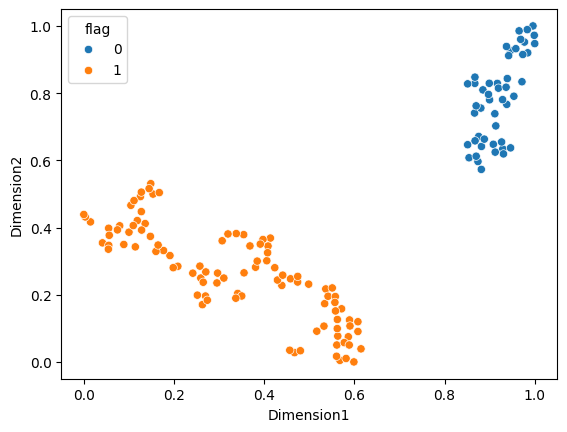

In [36]:
sns.scatterplot(data=res_iris, x='Dimension1', y='Dimension2', hue='flag')

Сравнение работы ручного и библиотечного алгоритмов на датасете mall

In [37]:
# кластеризация
start_time = datetime.datetime.now()
clustering = dbscan_clustering(cluster_df_mall, 0.05, 3)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_mall = data_mall_tsne_df.copy().head(0)
res_mall['flag'] = list(clustering.values())
row_num = 0
for key, value in clustering.items():
    for v in value:
        row = list(v)
        row.append(key)
        res_mall.loc[row_num] = row
        row_num += 1

# вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, list(res_mall['flag'].unique()))
outer_dist = outer_cluster_distance(res_mall, list(res_mall['flag'].unique()))
print(f'Внутрикластерное расстояние (вручную): {inner_dist}',
      f'Межкластерное расстояние (вручную): {outer_dist}',
      f'Время работы (вручную): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (вручную): 10.104590120531553
Межкластерное расстояние (вручную): 3311.3300152731777
Время работы (вручную): 0:00:00.250792


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

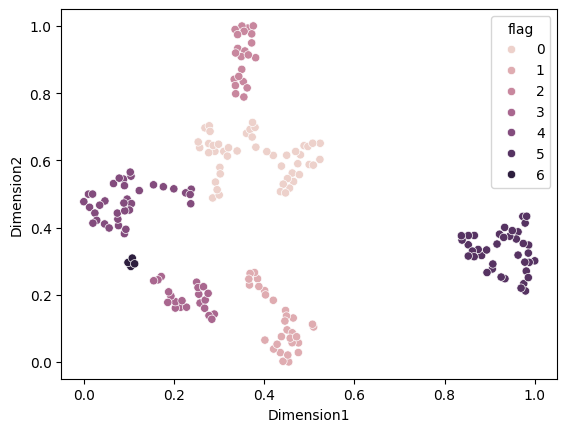

In [38]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')

In [39]:
# кластеризация
start_time = datetime.datetime.now()
clustering = DBSCAN(eps=0.05, min_samples=3).fit(data_mall_tsne_df)
end_time = datetime.datetime.now()
time_taken = end_time - start_time

# обработка результатов
res_mall = data_mall_tsne_df.copy()
res_mall['flag'] = clustering.labels_

# вычисление расстояний
inner_dist = inner_cluster_distance(res_mall, list(res_mall['flag'].unique()))
outer_dist = outer_cluster_distance(res_mall, list(res_mall['flag'].unique()))
print(f'Внутрикластерное расстояние (библиотека): {inner_dist}',
      f'Межкластерное расстояние (библиотека): {outer_dist}',
      f'Время работы (библиотека): {time_taken}',
      sep='\n')

Внутрикластерное расстояние (библиотека): 10.104590120531562
Межкластерное расстояние (библиотека): 3311.330015273183
Время работы (библиотека): 0:00:00.004988


<Axes: xlabel='Dimension1', ylabel='Dimension2'>

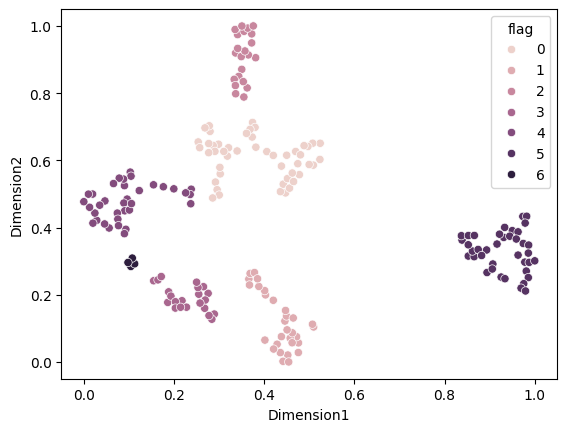

In [40]:
sns.scatterplot(data=res_mall, x='Dimension1', y='Dimension2', hue='flag')